# FITTING EFT COUNTERTERM TO QUIJOTE SIMULATIONS DATA

In [1]:
import numpy as np
import pandas
from scipy.interpolate import interp1d
from collections.abc import Iterable
from glob import glob

from scipy.stats import distributions
dnorm = distributions.norm.logpdf

%matplotlib inline
import matplotlib.pyplot as plt

## Data

In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.11, Ob0=0.049, Om0= 0.2685)

In [3]:
fnames = glob('/Users/c49734lf/Workspace/Datasets/Quijote_simulations/Pk/matter/fiducial_HR/*/Pk_m_z=0.5.txt')
arrays = [np.loadtxt(f, unpack=True) for f in fnames]
k, p = arrays[0]
pk = [arrays[i][1] for i in range(len(arrays))]

In [4]:
maximum = np.amax(pk, axis=0)
minimum = np.amin(pk, axis=0)
err = maximum - minimum

In [5]:
mean = np.mean(pk, axis=0)
var = np.var(pk, axis=0)
std = np.std(pk, axis=0)

In [6]:
cov0 = np.zeros((886, 886), int)
np.fill_diagonal(cov0, var)
cov = cov0

In [7]:
k_array = np.array(k)
p_array = np.array(mean)
cov_array = var

In [1]:
p_int = interp1d( k, p, fill_value="extrapolate")
cov_int = interp1d( k, var, fill_value="extrapolate")

## Theory

In [9]:
linear = np.loadtxt("/Users/c49734lf/Workspace/2019-2020/Ongoing projects/Unequal-time EFT/modules/SPT_Quijote_fit/plin05_k2.txt", unpack=True)
klin, plin = linear

In [10]:
spt = np.loadtxt("/Users/c49734lf/Workspace/2019-2020/Ongoing projects/Unequal-time EFT/modules/SPT_Quijote_fit/pspt05_k2.txt", unpack=True)
kspt, pspt = spt

In [10]:
d = np.loadtxt('/Users/c49734lf/Workspace/2019-2020/Ongoing projects/Unequal-time EFT/GitHub modules/example/Pfastpt.txt',unpack=True)
ks = d[:, 0]
pk, p22, p13 = d[:, 1], d[:, 2], d[:, 3]
p11_int = interp1d( ks, pk, fill_value="extrapolate")
p22_int = interp1d( ks, p22, fill_value="extrapolate")
p13_int = interp1d( ks, p13, fill_value="extrapolate")
powerk = (p11_int, p22_int, p13_int)
from skypy.power_spectrum import growth_function
g0 = growth_function(0, cosmo)
D0 = growth_function(0.5, cosmo) / g0
import sys
sys.path.append("../")
from matter import matter_power_spectrum_1loop 

In [11]:
pl_int = p11_int(klin)
pspt_int = matter_power_spectrum_1loop(klin, D0, powerk)

In [12]:
def peft(wavenumber, c2):
    
    if isinstance(wavenumber, pandas.Series):
        wavenumber = np.array(wavenumber)
    
    plk = p11_int(wavenumber)
    psk = matter_power_spectrum_1loop(wavenumber, D0, powerk)
    
    k2 = np.power(wavenumber, 2)
    plk_k2 = plk * k2
    
    klen = len(wavenumber)
    if isinstance(c2, Iterable):
        plk_k2 = plk_k2.reshape(klen,1)
        psk = psk.reshape(klen,1)
        
        
    return  (psk - c2 * plk_k2).T

In [15]:
kvalues = np.linspace(0.006,0.4,num=1000)
plin_model = D0**2 * p11_int(kvalues)
pspt_model = matter_power_spectrum_1loop(kvalues, D0, powerk)
p_data = p_int(kvalues)
cov_data = cov_int(kvalues)

def peft_model(c2):
    return peft(kvalues, c2)

### Plots

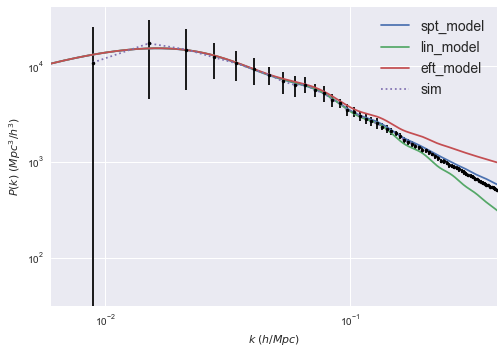

In [16]:
plt.loglog(kvalues, pspt_model, label='spt_model')
plt.loglog(kvalues, plin_model, label='lin_model')
plt.loglog(kvalues, peft_model(-5), label='eft_model')

plt.loglog(k, p, ':', label='sim')

plt.errorbar(k, p, yerr=err, fmt=".k", capsize=0)

plt.legend(fontsize=14)
plt.xlim(0.006, 0.4)
plt.xlabel("$k$ $(h/Mpc)$")
plt.ylabel("$P(k)$ $(Mpc^3/h^3)$")
plt.show()

## Maximum likelihood estimation

In [17]:
spt_array = D0**2 * p11_int(k)
lin_array = matter_power_spectrum_1loop(k, D0, powerk)

In [ ]:
def log_likelihood(theta, data, covariance):
    c2 = theta
     
    model = peft_model(c2)
    
    X = data - model
    C = covariance
    X_C = X/C
    
    if isinstance(c2, Iterable):
        clen = np.size(c2)
        logprob = np.arange(clen)
        for i in range(clen): 
            logprob[i] = -0.5 * np.dot(X[i], X_C[i])
    else:
        logprob = -0.5 * np.dot(X, X /C) 
    
    return logprob

In [19]:
from scipy.optimize import minimize

c2_true = 2

nll = lambda *args: -log_likelihood(*args)
initial = np.array([c2_true]) 
soln = minimize(nll, initial, args=(p_data, cov_data))
c_ml = soln.x

print("Maximum likelihood estimates:")
print(c_ml)

Maximum likelihood estimates:
[2.]


## Marginalization & uncertainty estimation

In [20]:
def log_prior(theta):
    #return dnorm(theta, 0,  1) # lognormal
    return 1/theta #flat

In [ ]:
def log_probability(theta, data, covariance):
    return log_prior(theta) + log_likelihood(theta, data, covariance)

In [22]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(50, 1)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(p_data, cov_data))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [01:26<00:00, 58.03it/s]


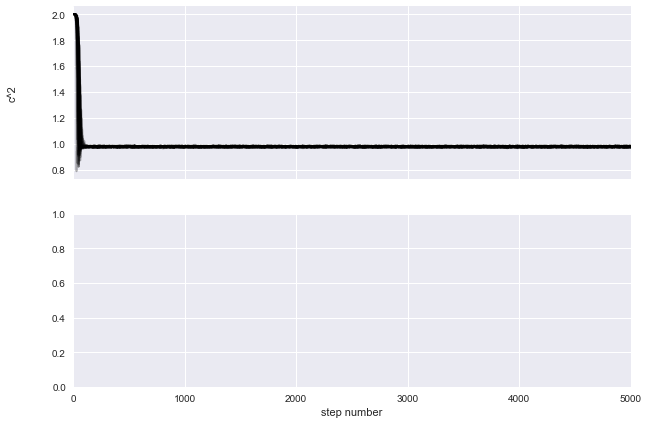

In [23]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["c^2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [24]:
tau = sampler.get_autocorr_time()
print(tau)

[54.83072783]


In [25]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(16300, 1)


## Results

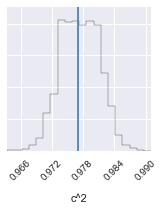

In [28]:
import corner
c2_true = 0.977
fig = corner.corner(
    flat_samples, labels=labels, truths=[c2_true]
);

<IPython.core.display.Math object>

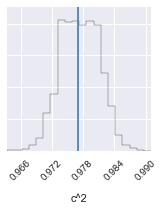

In [29]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
fig

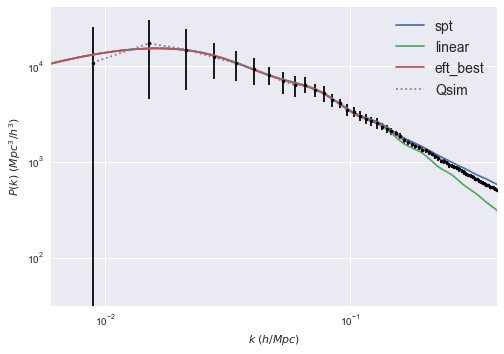

In [30]:
best_fit = mcmc[1]
plt.loglog(kvalues, pspt_model, label='spt')
plt.loglog(kvalues, plin_model, label='linear')
plt.loglog(kvalues, peft_model(best_fit), label='eft_best')

plt.loglog(k, p, ':', label='Qsim')

plt.errorbar(k, p, yerr=err, fmt=".k", capsize=0)

plt.legend(fontsize=14)
plt.xlim(0.006, 0.4)
plt.xlabel("$k$ $(h/Mpc)$")
plt.ylabel("$P(k)$ $(Mpc^3/h^3)$");